# Market-cap vs. Equal Weight

In [1]:
library(DBI)
library(plutoDbR)
library(plutoR)
library(tidyverse)
options("scipen"=999)
options(stringsAsFactors = FALSE)
source("/usr/share/pluto/config.R")
source("/usr/share/pluto/goofy/plot.common.R")
source("/usr/share/pluto/goofy/misc.common.R")

library(ggthemes)
library(quantmod)
library(PerformanceAnalytics)
library(reshape2)
library(ggrepel)

options(repr.plot.width=16, repr.plot.height=8)

#initialize
indices<-Indices()

In [2]:
# grab Wilshire data

mktCap <- indices$WilshireTimeSeries() %>%
    inner_join(indices$WilshireMeta()) %>%
    filter(NAME == 'Wilshire 5000 Total Market') %>%
    select(TIME_STAMP, CLOSE) %>%
    collect() %>%
    mutate(TIME_STAMP = as.Date(TIME_STAMP))

eqWt <- indices$WilshireTimeSeries() %>%
    inner_join(indices$WilshireMeta()) %>%
    filter(NAME == 'Wilshire 5000 Equal Weighted') %>%
    select(TIME_STAMP, CLOSE) %>%
    collect() %>%
    mutate(TIME_STAMP = as.Date(TIME_STAMP))

In [3]:
processData <- function(data){
    dataXts <- xts(data$CLOSE, data$TIME_STAMP)
    dataMonthly <- to.period(dataXts, 'months')[,4]
    dataMonthly <- Common.NormalizeMonthlyDates(dataMonthly)
    
    dataYrs <- data.frame(TIME_STAMP = index(dataMonthly), coredata(dataMonthly)) %>%
        mutate(Y = year(TIME_STAMP)) %>%
        group_by(Y) %>%
        summarize(CNT = n())
    
    dataYrs <- dataYrs %>%
        ungroup() %>%
        filter(CNT > 6) %>%
        select(Y)

    dataMonthly <- dataMonthly[year(index(dataMonthly)) %in% dataYrs$Y,]
    
    return(dataMonthly)
}

In [4]:
mktCapXts <- processData(mktCap)
eqlWtXts <- processData(eqWt)

allXts <- na.omit(merge(mktCapXts, eqlWtXts))

In [5]:
mktCapRets <- monthlyReturn(allXts[,1])
eqlWtRets <- monthlyReturn(allXts[,2])

In [6]:
monthlies <- merge(mktCapRets, eqlWtRets)
names(monthlies) <- c('Total Market', 'Equal Weighted')
monthlies <- na.omit(monthlies)

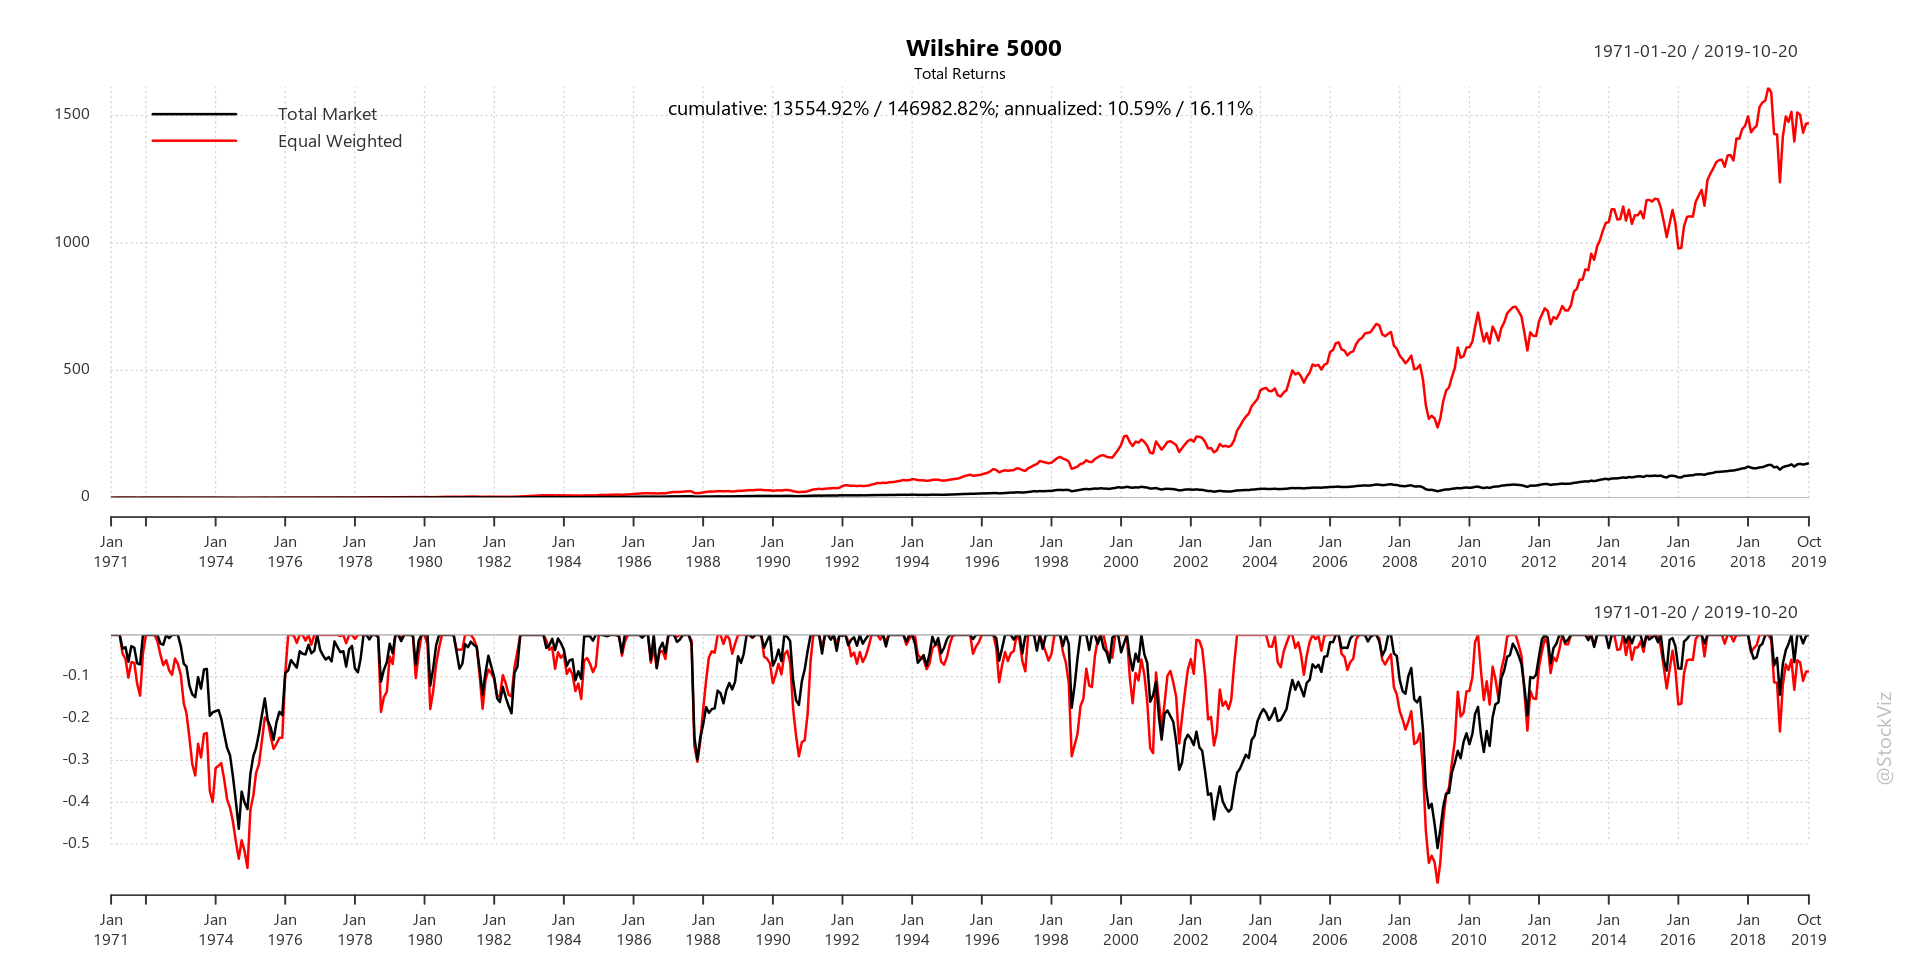

In [7]:
Common.PlotCumReturns(monthlies, "Wilshire 5000", "Total Returns")

In [8]:
mktCapYRets <- yearlyReturn(allXts[,1])
eqlWtYRets <- yearlyReturn(allXts[,2])

In [9]:
yearlies <- merge(mktCapYRets, eqlWtYRets)
names(yearlies) <- c('Total Market', 'Equal Weighted')
yearlies <- na.omit(yearlies)

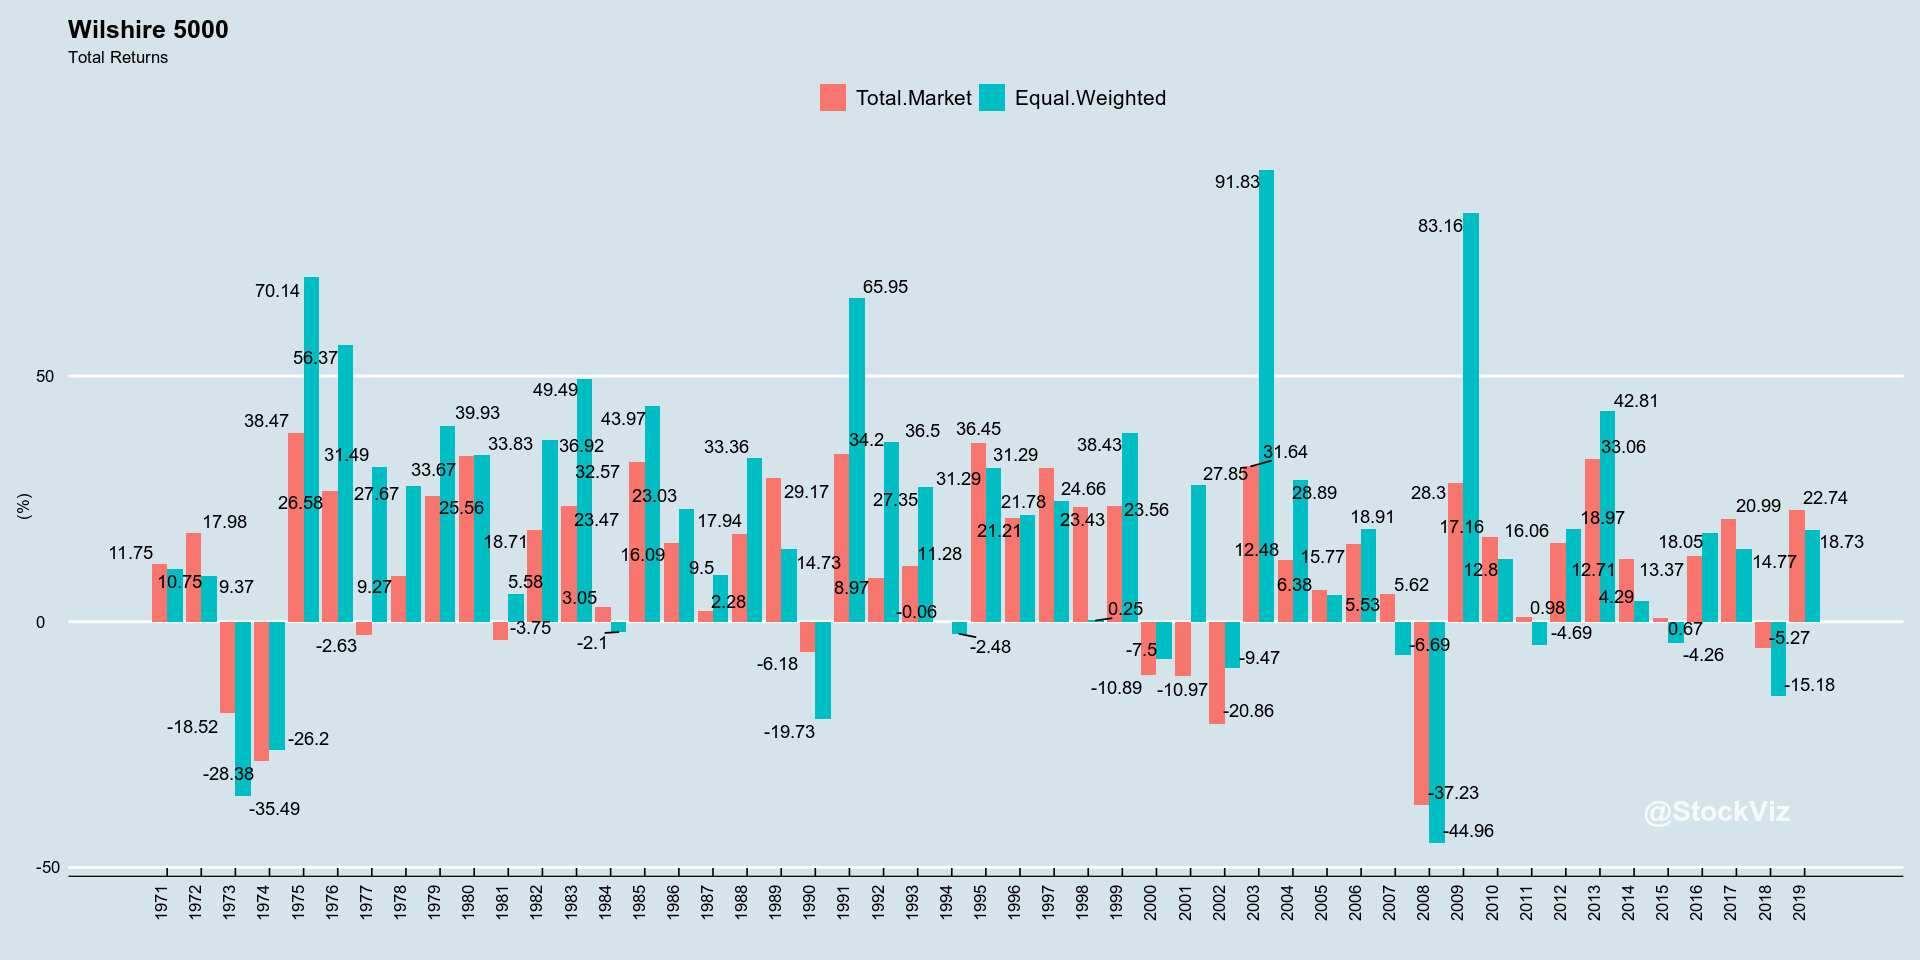

In [10]:
toPlot <- data.frame(100*yearlies)
toPlot$YEAR <- year(index(yearlies))
mDf <- melt(toPlot, id='YEAR')
ggplot(mDf, aes(x=YEAR, y=value, fill=variable)) +
    theme_economist() +
    theme(axis.text.x=element_text(angle=90, hjust=1)) +
    geom_bar(stat="identity", position=position_dodge()) +
    scale_x_continuous(labels=toPlot$YEAR, breaks=toPlot$YEAR) +
    geom_text_repel(aes(label= round(value, 2)), position = position_dodge(0.9)) +
    labs(x='', y='(%)', fill='', title="Wilshire 5000", subtitle="Total Returns") +
    annotate("text", x=max(toPlot$YEAR), y=min(mDf$value), 
             label = "@StockViz", hjust=1.1, vjust=-1.1, 
             col="white", cex=6, fontface = "bold", alpha = 0.8)  

In [11]:
#on a rolling YR-year basis, how many months did equal weight out-perform market weight?
YR <- 5 #years
lookback <- YR * 12 #months
eqGtMktMonthly <- ifelse(monthlies[,2] > monthlies[,1], 1, 0)
eqGtMkt <- rollapply(eqGtMktMonthly, lookback, sum)
eqGtMkt <- na.omit(eqGtMkt)

#on a rolling YR-year basis, what was the difference in returns between equal-weight and market weight?
eqMinusMkt <- rollapply(monthlies, lookback, function(X) {
    Return.cumulative(X[,2]) - Return.cumulative(X[,1])
}, by.column = F)

eqMinusMkt <- na.omit(eqMinusMkt)

In [12]:
plotLine <- function(dXts, mainTitle, subTitle){
    mDf <- data.frame(dXts)
    names(mDf) <- c('V')
    mDf$T <- index(eqGtMkt)
    ggplot(mDf, aes(x=T, y=V)) +
        theme_economist() +
        geom_line() + 
        labs(x='', y='', fill='', title=mainTitle, subtitle=subTitle) +
        annotate("text", x=max(mDf$T), y=min(mDf$V), 
             label = "@StockViz", hjust=1.1, vjust=-1.1, 
             col="white", cex=6, fontface = "bold", alpha = 0.8)
}

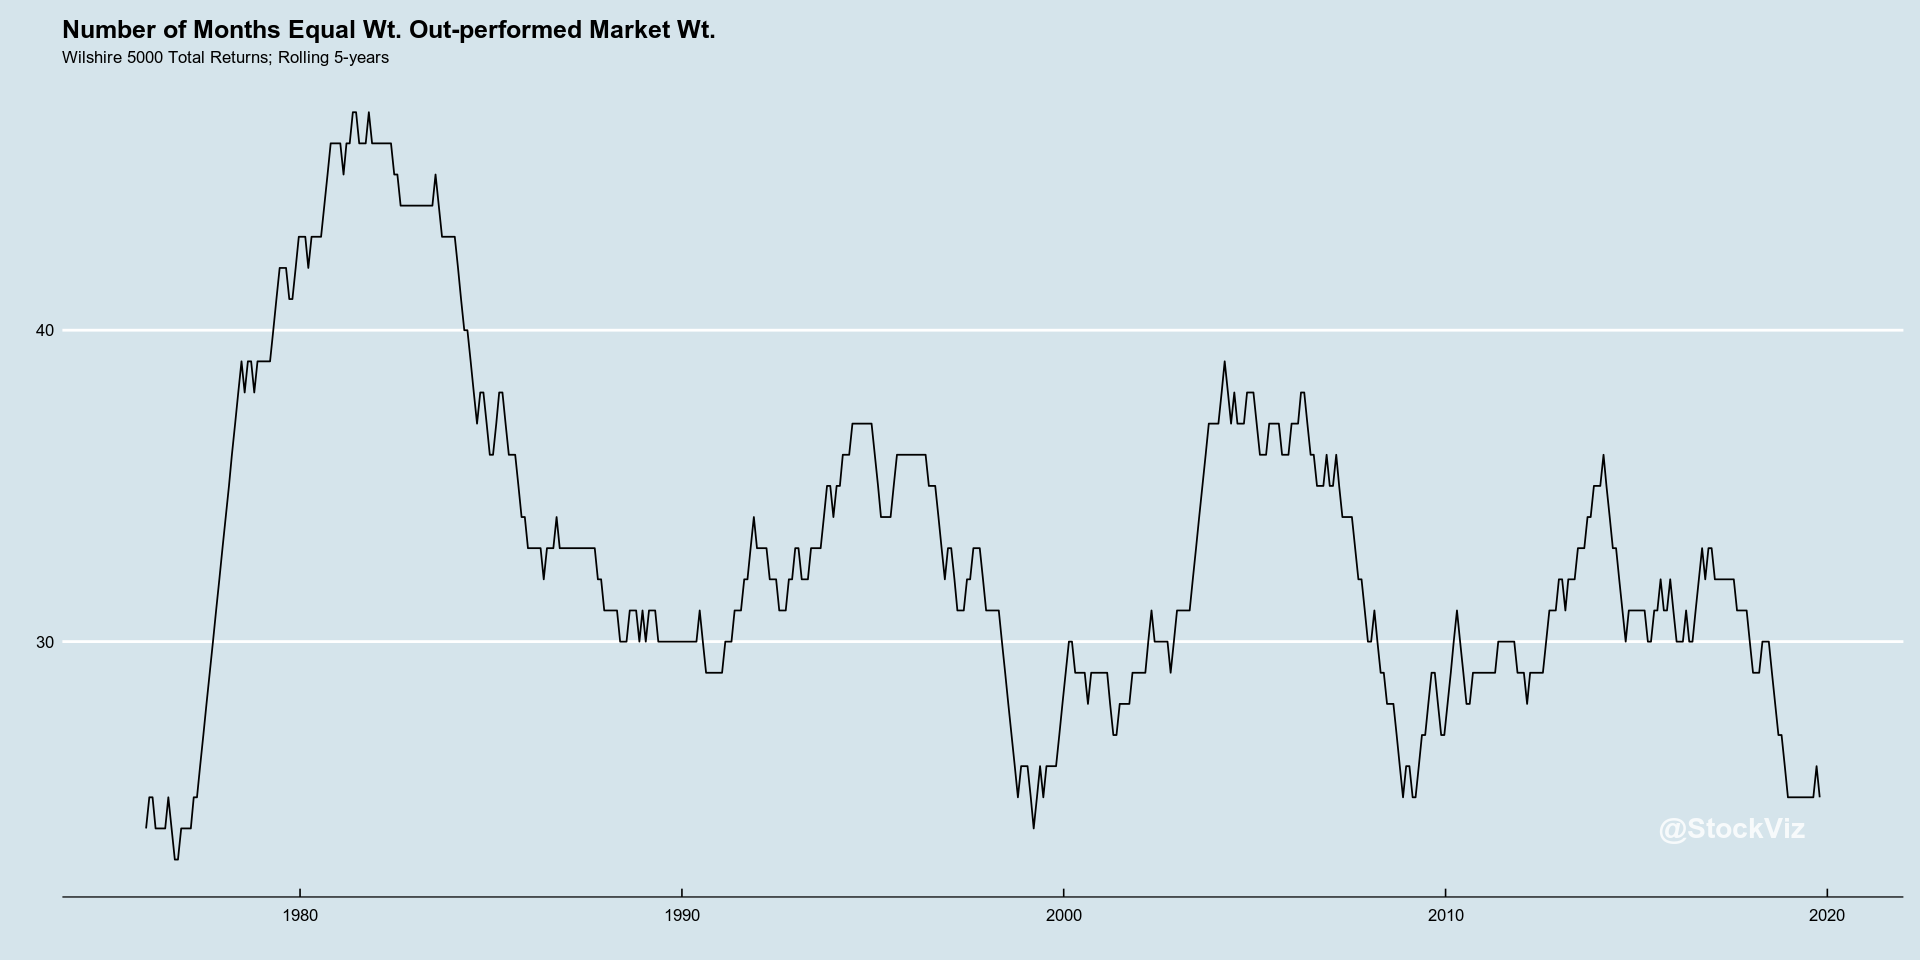

In [13]:
plotLine(eqGtMkt, "Number of Months Equal Wt. Out-performed Market Wt.", sprintf("Wilshire 5000 Total Returns; Rolling %d-years", YR))

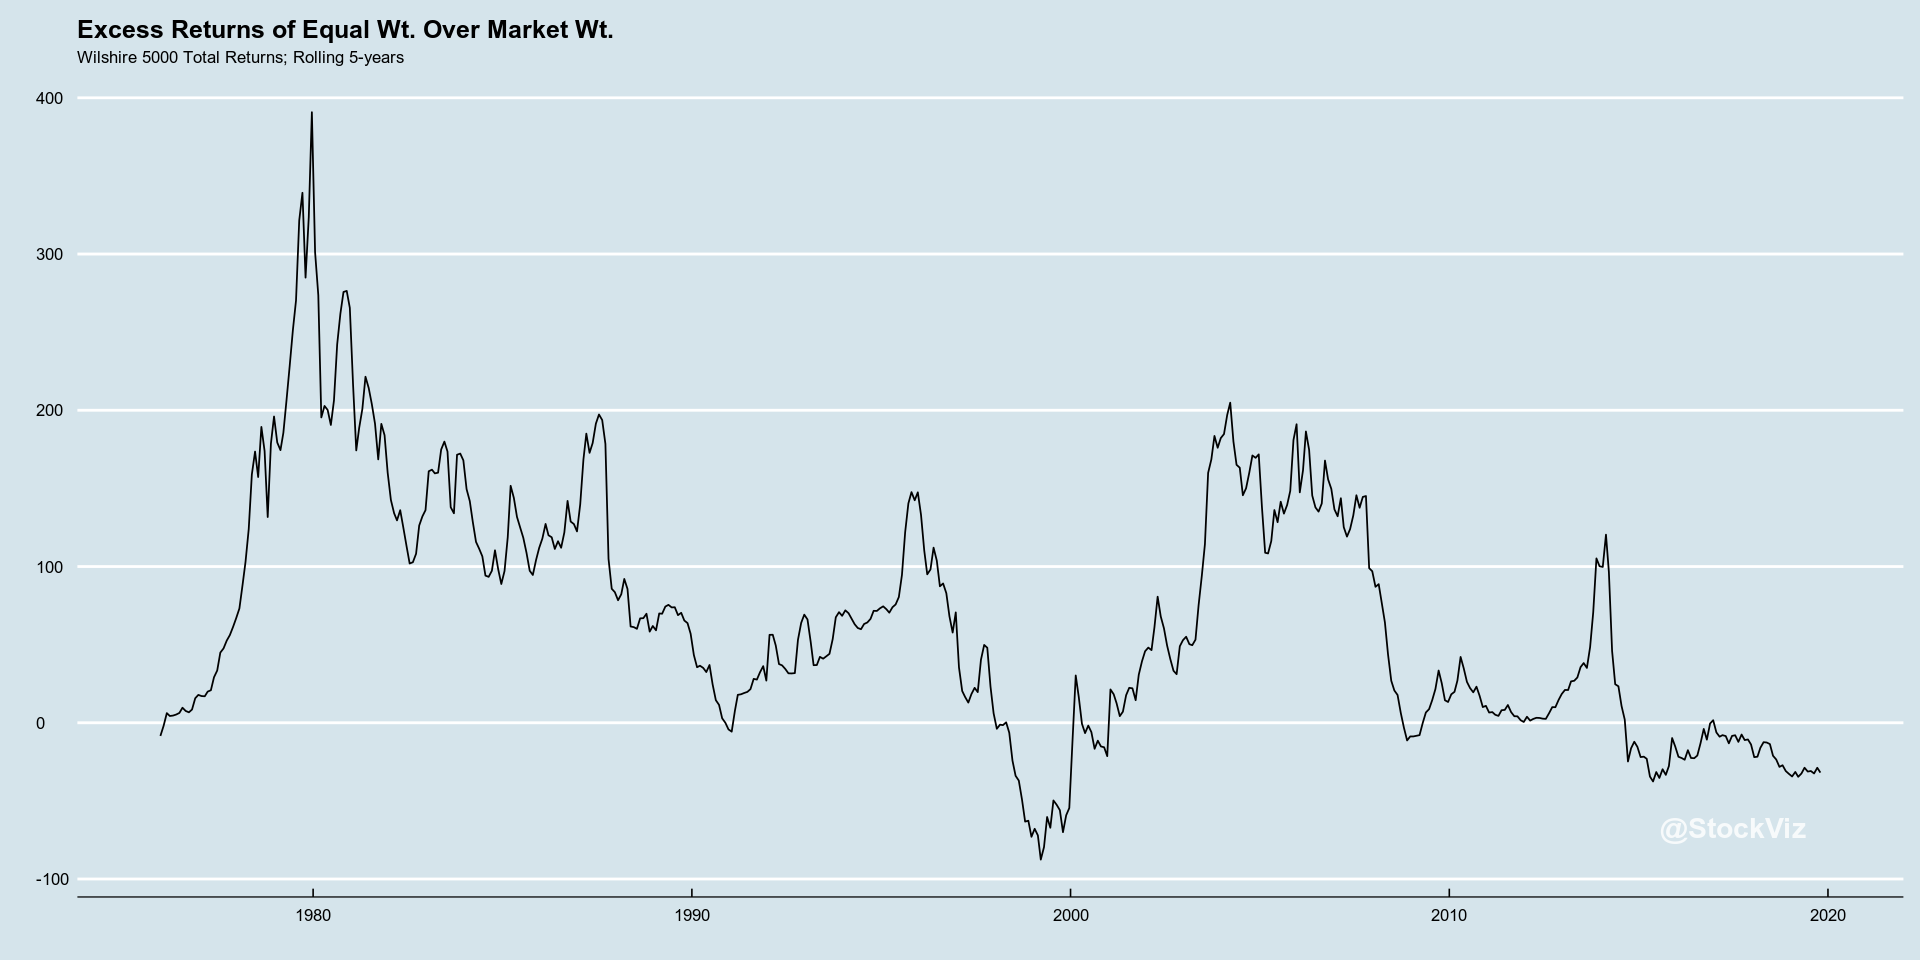

In [14]:
plotLine(100*eqMinusMkt, "Excess Returns of Equal Wt. Over Market Wt.", sprintf("Wilshire 5000 Total Returns; Rolling %d-years", YR))

In [15]:
print("Market weight summary stats:")
print(summary(monthlies[,1]))
print("std-dev:")
print(sd(monthlies[,1]))
print("Equal weight summary stats:")
print(summary(monthlies[,2]))
print("std-dev:")
print(sd(monthlies[,2]))

[1] "Market weight summary stats:"
     Index             Total Market     
 Min.   :1971-01-20   Min.   :-0.22779  
 1st Qu.:1983-03-27   1st Qu.:-0.01673  
 Median :1995-06-04   Median : 0.01294  
 Mean   :1995-06-05   Mean   : 0.00942  
 3rd Qu.:2007-08-12   3rd Qu.: 0.03816  
 Max.   :2019-10-20   Max.   : 0.16566  
[1] "std-dev:"
[1] 0.04437811
[1] "Equal weight summary stats:"
     Index            Equal Weighted    
 Min.   :1971-01-20   Min.   :-0.25487  
 1st Qu.:1983-03-27   1st Qu.:-0.02037  
 Median :1995-06-04   Median : 0.01412  
 Mean   :1995-06-05   Mean   : 0.01429  
 3rd Qu.:2007-08-12   3rd Qu.: 0.04699  
 Max.   :2019-10-20   Max.   : 0.31422  
[1] "std-dev:"
[1] 0.05952081


In [16]:
ir <- rollapply(monthlies, lookback, function(X) InformationRatio(X[,2], X[,1]), by.column = F) 

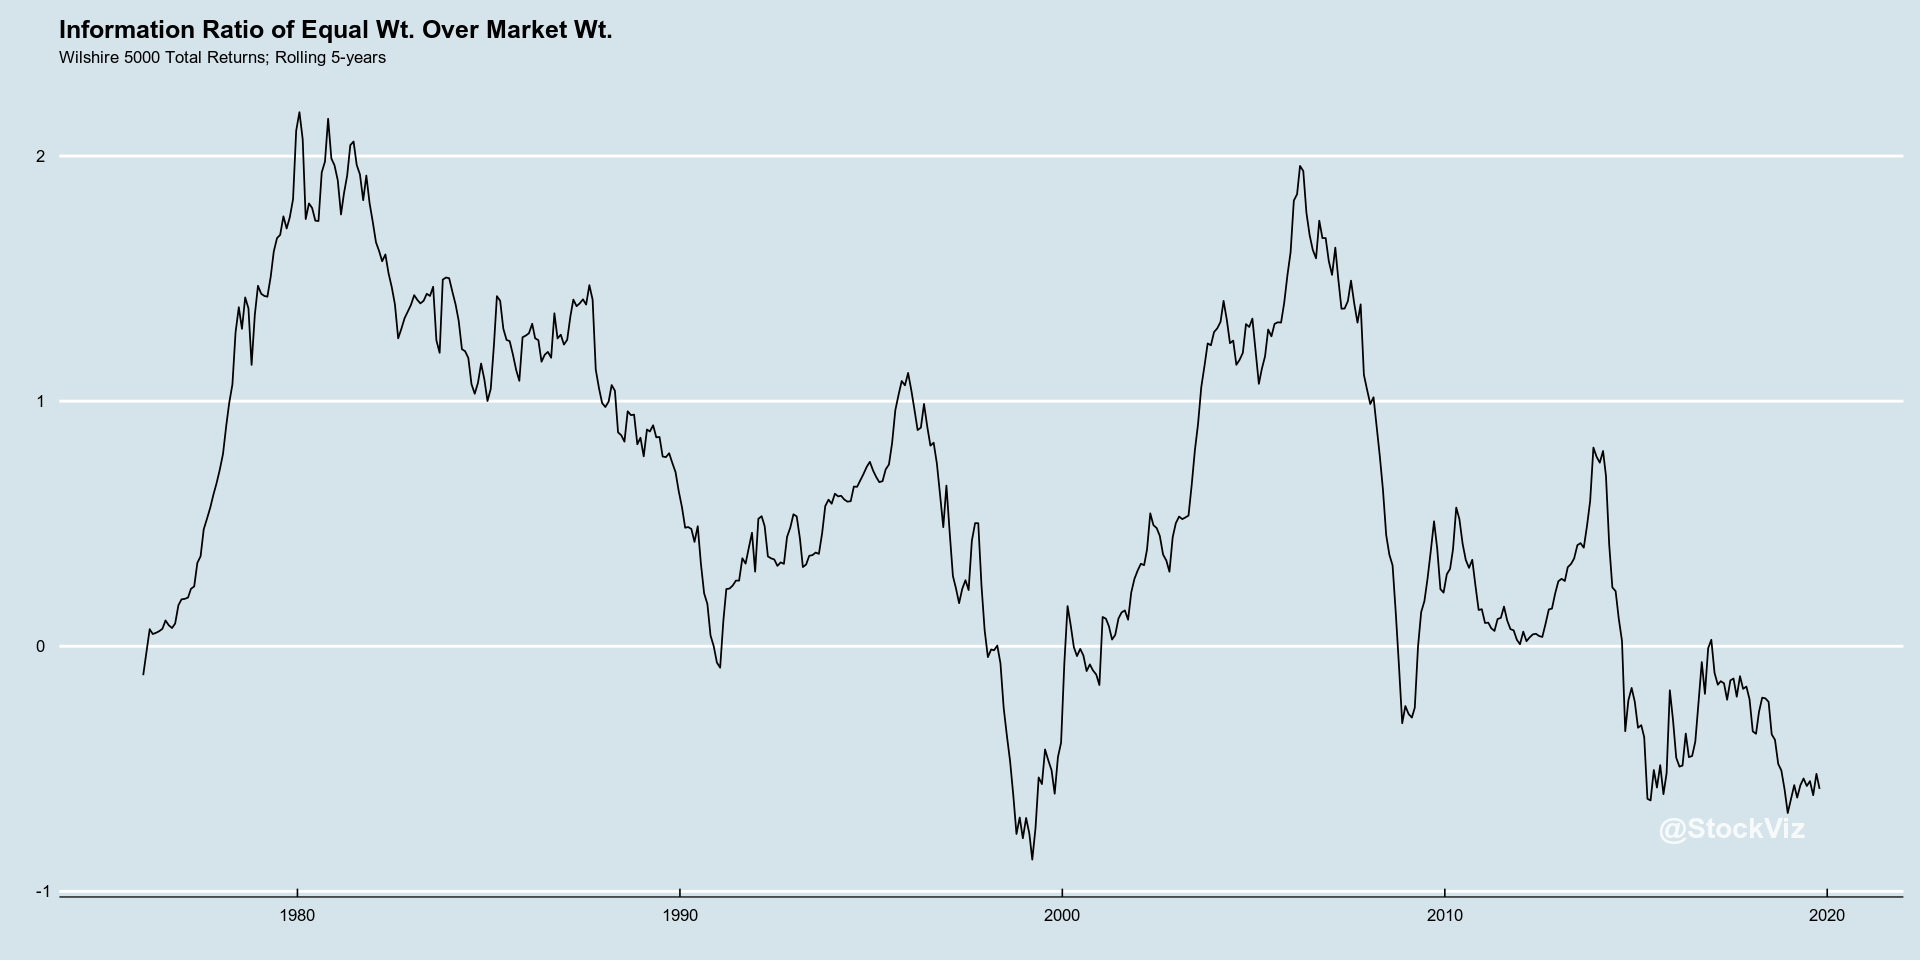

In [17]:
ir <- na.omit(ir)
plotLine(ir, "Information Ratio of Equal Wt. Over Market Wt.", sprintf("Wilshire 5000 Total Returns; Rolling %d-years", YR))

This notebook was created using [pluto](https://pluto.studio). Thank you for playing fair!